# GitHub Repository 기반 Q&A 챗봇


In [1]:
from dotenv import load_dotenv

load_dotenv()

True

LangChain 추적


In [2]:
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Code Analysis 0701 Test 02"

### 데이터 준비


GitHub Repository 를 다운로드 받습니다. 이번 예제는 langchain-ai 공식 Repository 로 진행합니다.

- !git clone 을 사용하여 Repository clone

다른 저장소의 파일을 사용하고 싶다면, `root_dir`을 여러분의 저장소의 루트 디렉토리로 변경하세요.


저는 `/Users/teddy/Dev/github/langchain` 위치에 `langchain` reposotory 를 clone 하였습니다. 아래의 경로는 본인의 경로에 맞게 바꾸어 주어야 합니다.


In [3]:
!ls "/home/charles/ai_study/langgraph/libs"

cli  langgraph	sdk-js	sdk-py


## 도큐먼트 로더


여기서 모든 패키지의 파일을 불러오지 않습니다. 핵심 기능을 포함하는 특정 폴더의 파일만 불러오도록 아래와 같이 정의해 주었습니다.


In [4]:
# Root 경로
repo_root = "/home/charles/ai_study/langgraph/libs"
#repo_root = "/home/charles/ai_study/langchain/libs"

# 불러오고자 하는 패키지 경로
#repo_core = repo_root + "/core/langchain_core"
#repo_community = repo_root + "/community/langchain_community"
#repo_experimental = repo_root + "/experimental/langchain_experimental"
#repo_parters = repo_root + "/partners"
#repo_text_splitter = repo_root + "/text_splitters/langchain_text_splitters"
#repo_cookbook = repo_root + "/cookbook"
repo_cli = repo_root + "/cli"
repo_langgraph = repo_root + "/langgraph"
repo_js = repo_root + "/sdk-js"
repo_py = repo_root + "/sdk-py"



In [5]:
# langchain의 여러 모듈을 가져옵니다.
from langchain_text_splitters import Language
from langchain.document_loaders.generic import GenericLoader
from langchain.document_loaders.parsers import LanguageParser

# 불러온 문서를 저장할 빈 리스트를 생성합니다.
py_documents = []

#for path in [repo_core, repo_community, repo_experimental, repo_parters,repo_text_splitter]:
for path in [repo_cli, repo_langgraph, repo_js, repo_py]:
    # GenericLoader를 사용하여 파일 시스템에서 문서를 로드합니다.
    loader = GenericLoader.from_filesystem(
        path,  # 문서를 불러올 경로
        glob="**/*",  # 모든 하위 폴더와 파일을 대상으로 함
        suffixes=[".py"],  # .py 확장자를 가진 파일만 대상으로 함
        parser=LanguageParser(
            language=Language.PYTHON, parser_threshold=30
        ),  # 파이썬 언어의 문서를 파싱하기 위한 설정
    )
    # 로더를 통해 불러온 문서들을 documents 리스트에 추가합니다.
    py_documents.extend(loader.load())

print(f".py 파일의 개수: {len(py_documents)}")

.py 파일의 개수: 473


다음은 `.mdx` 확장자를 가진 파일을 `TextLoader` 를 사용하여 불러옵니다. `.mdx` 파일은 Jupyter Notebook 파일을 마크다운 형식으로 변환한 파일이며, 유용한 예제를 포함하고 있으므로 이를 DB 에 추가하기 위해 도큐먼트 형식으로 로드압니다.


In [6]:
import os

# TextLoader 모듈을 불러옵니다.
from langchain_community.document_loaders import TextLoader

# 검색할 최상위 디렉토리 경로를 정의합니다.
#root_dir = "/home/charles/ai_study/langchain/"
root_dir = "/home/charles/ai_study/langgraph/"

mdx_documents = []
# os.walk를 사용하여 root_dir부터 시작하는 모든 디렉토리를 순회합니다.
for dirpath, dirnames, filenames in os.walk(root_dir):
    # 각 디렉토리에서 파일 목록을 확인합니다.
    for file in filenames:
        # 파일 확장자가 .mdx인지 확인하고, 경로 내 '*venv/' 문자열이 포함되지 않는지도 체크합니다.
        if (file.endswith(".mdx")) and "*venv/" not in dirpath:
            try:
                # TextLoader를 사용하여 파일의 전체 경로를 지정하고 문서를 로드합니다.
                loader = TextLoader(os.path.join(dirpath, file), encoding="utf-8")
                # 로드한 문서를 분할하여 documents 리스트에 추가합니다.
                mdx_documents.extend(loader.load())
            except Exception:
                # 파일 로드 중 오류가 발생하면 이를 무시하고 계속 진행합니다.
                pass

# 최종적으로 불러온 문서의 개수를 출력합니다.
print(f".mdx 파일의 개수: {len(mdx_documents)}")

.mdx 파일의 개수: 0


## Chunk 분할


파일들을 청크로 나누어 봅시다.


In [7]:
# RecursiveCharacterTextSplitter 모듈을 가져옵니다.
from langchain_text_splitters import RecursiveCharacterTextSplitter

# RecursiveCharacterTextSplitter 객체를 생성합니다. 이 때, 파이썬 코드를 대상으로 하며,
# 청크 크기는 2000, 청크간 겹치는 부분은 200 문자로 설정합니다.
py_splitter = RecursiveCharacterTextSplitter.from_language(
    language=Language.PYTHON, chunk_size=2000, chunk_overlap=200
)

# py_docs 변수에 저장된 문서들을 위에서 설정한 청크 크기와 겹치는 부분을 고려하여 분할합니다.
py_docs = py_splitter.split_documents(py_documents)

# 분할된 텍스트의 개수를 출력합니다.
print(f"분할된 .py 파일의 개수: {len(py_docs)}")

mdx_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000, chunk_overlap=200)

# mdx_docs 변수에 저장된 문서들을 위에서 설정한 청크 크기와 겹치는 부분을 고려하여 분할합니다.
mdx_docs = mdx_splitter.split_documents(mdx_documents)

# 분할된 텍스트의 개수를 출력합니다.
print(f"분할된 .mdx 파일의 개수: {len(mdx_docs)}")

분할된 .py 파일의 개수: 858
분할된 .mdx 파일의 개수: 0


로드한 도큐먼트를 합칩니다.


In [8]:
combined_documents = py_docs + mdx_docs
print(f"총 도큐먼트 개수: {len(combined_documents)}")

총 도큐먼트 개수: 858


## Embedding


In [9]:
# langchain_openai와 langchain의 필요한 모듈들을 가져옵니다.
from langchain_openai import OpenAIEmbeddings
from langchain.embeddings import CacheBackedEmbeddings
from langchain.storage import LocalFileStore

# 로컬 파일 저장소를 사용하기 위해 LocalFileStore 인스턴스를 생성합니다.
# './cache/' 디렉토리에 데이터를 저장합니다.
store = LocalFileStore("./cache/")

# OpenAI 임베딩 모델 인스턴스를 생성합니다. 모델명으로 "text-embedding-3-small"을 사용합니다.
embeddings = OpenAIEmbeddings(
    model="text-embedding-3-small", disallowed_special=())

# CacheBackedEmbeddings를 사용하여 임베딩 계산 결과를 캐시합니다.
# 이렇게 하면 임베딩을 여러 번 계산할 필요 없이 한 번 계산된 값을 재사용할 수 있습니다.
cached_embeddings = CacheBackedEmbeddings.from_bytes_store(
    embeddings, store, namespace=embeddings.model
)

## Vector DB


- `from_documents`: 이 메서드는 문서 컬렉션과 이에 해당하는 임베딩을 받아 벡터 인덱스를 생성합니다. 여기서는 `combined_documents` 로부터 벡터를 생성하고, 이 벡터들은 `cached_embeddings` 을 통해 임베딩된 데이터를 사용합니다.
- `save_local`: 이 메서드는 생성된 FAISS 인덱스를 지정된 로컬 폴더에 저장합니다. 이 폴더명은 `FAISS_DB_INDEX` 변수에 저장되어 있습니다.


In [10]:
# langchain_community 모듈에서 FAISS 클래스를 가져옵니다.
from langchain_community.vectorstores import FAISS

# 로컬에 저장할 FAISS 인덱스의 폴더 이름을 지정합니다.
FAISS_DB_INDEX = "langchain_faiss"

# combined_documents 문서들과 cached_embeddings 임베딩을 사용하여
# FAISS 데이터베이스 인스턴스를 생성합니다.
db = FAISS.from_documents(combined_documents, cached_embeddings)

# 생성된 데이터베이스 인스턴스를 지정한 폴더에 로컬로 저장합니다.
db.save_local(folder_path=FAISS_DB_INDEX)

저장한 FAISS 데이터베이스를 불러옵니다. 이후 실행시에는 새롭게 DB 에 저장할 필요없이 아래 코드만 실행하면 됩니다.


In [11]:
# langchain_community 모듈에서 FAISS 클래스를 가져옵니다.
from langchain_community.vectorstores import FAISS

# FAISS 클래스의 load_local 메서드를 사용하여 저장된 벡터 인덱스를 로드합니다.
db = FAISS.load_local(
    FAISS_DB_INDEX,  # 로드할 FAISS 인덱스의 디렉토리 이름
    cached_embeddings,  # 임베딩 정보를 제공
    allow_dangerous_deserialization=True,  # 역직렬화를 허용하는 옵션
)

## Retriever


In [12]:
# MMR을 사용하여 검색을 수행하는 retriever를 생성합니다.
faiss_retriever = db.as_retriever(search_type="mmr", search_kwargs={"k": 10})

In [13]:
# langchain.retrievers 모듈에서 BM25Retriever 클래스를 가져옵니다.
from langchain.retrievers import BM25Retriever

# 문서 컬렉션을 사용하여 BM25 검색 모델 인스턴스를 생성합니다.
bm25_retriever = BM25Retriever.from_documents(
    combined_documents  # 초기화에 사용할 문서 컬렉션
)

# BM25Retriever 인스턴스의 k 속성을 10으로 설정하여,
# 검색 시 최대 10개의 결과를 반환하도록 합니다.
bm25_retriever.k = 10

In [14]:
# langchain.retrievers 모듈에서 EnsembleRetriever 클래스를 가져옵니다.
from langchain.retrievers import EnsembleRetriever

# EnsembleRetriever 인스턴스를 생성합니다.
# 이때, BM25 검색 모델과 FAISS 검색 모델을 결합하여 사용합니다.
ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, faiss_retriever],  # 사용할 검색 모델의 리스트
    weights=[0.6, 0.4],  # 각 검색 모델의 결과에 적용할 가중치
    search_type="mmr",  # 검색 결과의 다양성을 증진시키는 MMR 방식을 사용
)

## 파이프라인 연결

chain 을 구성합니다.


### 프롬프트


In [15]:
from langchain_core.prompts import PromptTemplate

prompt = PromptTemplate.from_template(
    """당신은 20년차 AI 개발자입니다. 당신의 임무는 주어진 질문에 대하여 최대한 문서의 정보를 활용하여 답변하는 것입니다.
문서는 Python 코드에 대한 정보를 담고 있습니다. 따라서, 답변을 작성할 때에는 Python 코드에 대한 상세한 code snippet을 포함하여 작성해주세요.
최대한 자세하게 답변하고, 한글로 답변해 주세요. 주어진 문서에서 답변을 찾을 수 없는 경우, "문서에 답변이 없습니다."라고 답변해 주세요.
답변은 출처(source)를 반드시 표기해 주세요.

#참고문서:
{context}

#질문:
{question}

#답변: 

출처:
- source1
- source2
- ...                             
"""
)

### LLM 정의


In [16]:
from langchain.callbacks.base import BaseCallbackHandler
from langchain_core.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain_core.callbacks.manager import CallbackManager
from langchain_core.runnables import ConfigurableField
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

from langchain_community.chat_models import ChatOllama
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic


class StreamCallback(BaseCallbackHandler):
    def on_llm_new_token(self, token: str, **kwargs):
        print(token, end="", flush=True)


llm = ChatOpenAI(
    #model="gpt-4-turbo-preview",
    model="gpt-4o",
    temperature=0,
    streaming=True,
    callbacks=[StreamCallback()],
).configurable_alternatives(
    # 이 필드에 id를 부여합니다.
    # 최종 실행 가능한 객체를 구성할 때, 이 id를 사용하여 이 필드를 구성할 수 있습니다.
    ConfigurableField(id="llm"),
    # 기본 키를 설정합니다.
    default_key="gpt4",
    claude=ChatAnthropic(
        model="claude-3-opus-20240229",
        temperature=0,
        streaming=True,
        callbacks=[StreamCallback()],
    ),
    gpt3=ChatOpenAI(
        model="gpt-3.5-turbo",
        temperature=0,
        streaming=True,
        callbacks=[StreamCallback()],
    ),
    ollama1=ChatOllama(
        model="aya:8b",
        callback_manager=CallbackManager([StreamingStdOutCallbackHandler()]),
    ),
    ollama2=ChatOllama(
        model="llama3:latest",
        callback_manager=CallbackManager([StreamingStdOutCallbackHandler()]),
    ),
    ollama3=ChatOllama(
        model="qwen2:latest",
        callback_manager=CallbackManager([StreamingStdOutCallbackHandler()]),
    ),
)

In [17]:
# 체인을 생성합니다.
rag_chain = (
    {"context": ensemble_retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

## 질의-응답 테스트


In [19]:
answer = rag_chain.with_config(configurable={"llm": "gpt4"}).invoke(
    "javascript 사용방법을 알려주세요"
)

문서에 답변이 없습니다.

출처:
- 문서 전체 검토 결과, JavaScript 사용 방법에 대한 정보는 포함되어 있지 않습니다.

#smith 추적 결과 URL
https://smith.langchain.com/public/5c210146-049e-4807-96cd-96ff5647403e/r

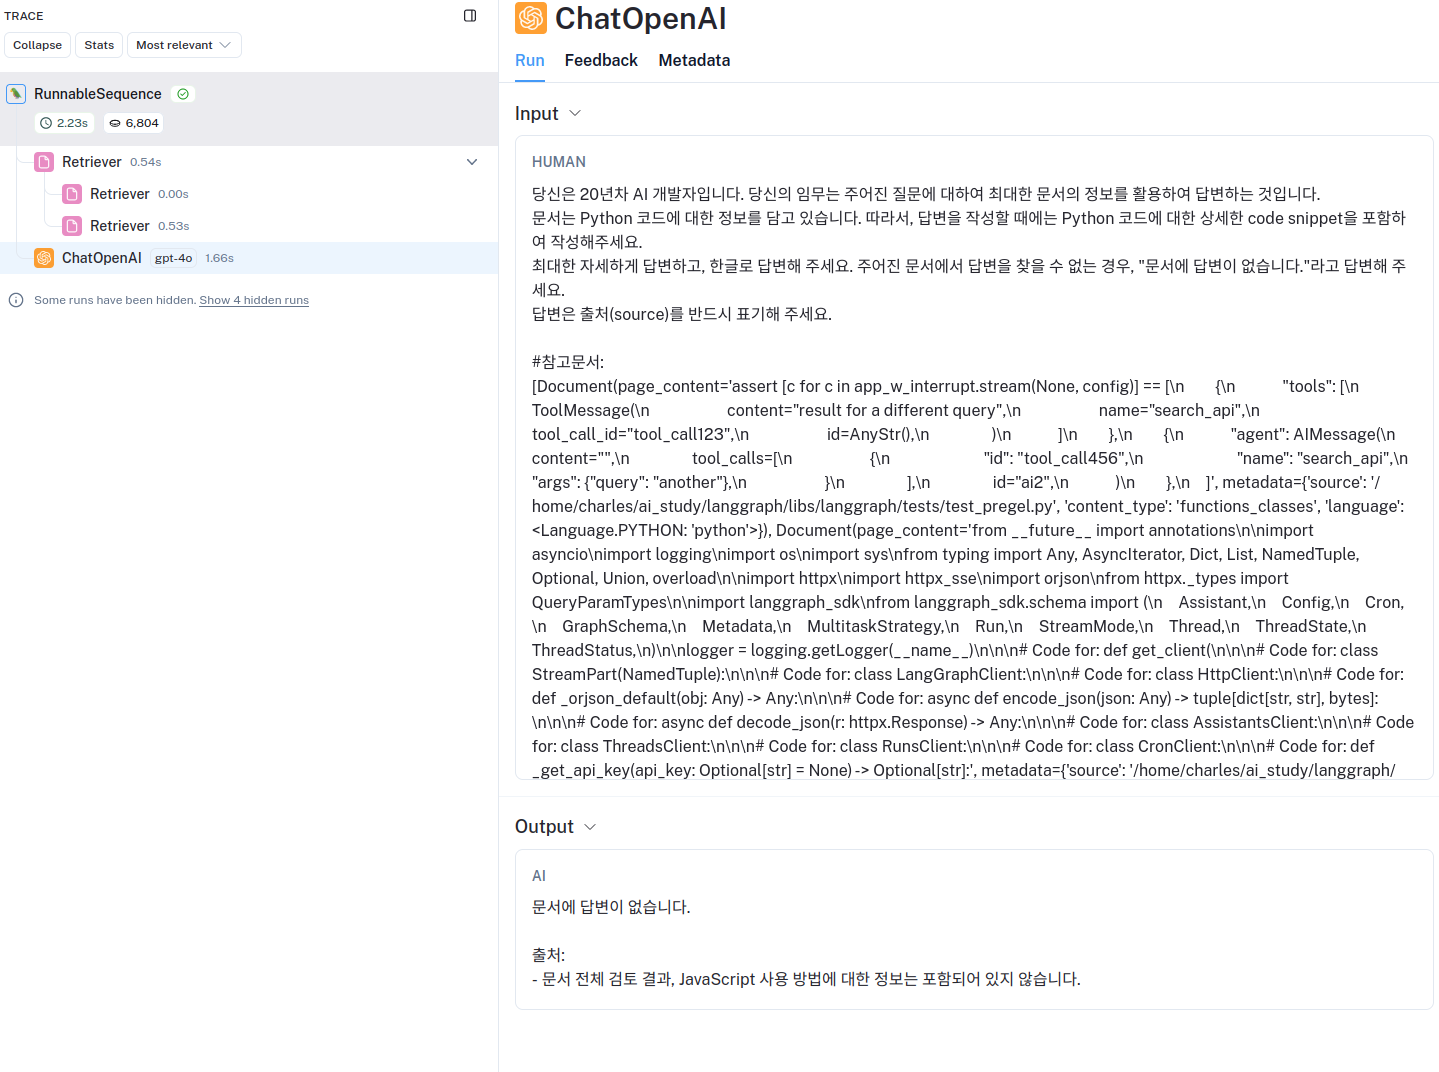

In [20]:
answer = rag_chain.with_config(configurable={"llm": "ollama1"}).invoke(
    "javascript 사용방법을 알려주세요"
)

JavaScript는 웹 브라우저에서 실행되는 가장 널리 사용되는 프로그래밍 언어 중 하나입니다. 동적이며 대화형 웹사이트 및 웹 애플리케이션을 구축하는 데 자주 사용됩니다. JavaScript를 사용하여 다음과 같은 작업을 수행할 수 있습니다.

1. HTML 콘텐츠 조작: JavaScript를 사용하면 DOM(Document Object Model)을 조작하여 HTML 페이지의 콘텐츠를 동적으로 변경할 수 있습니다. 이를 통해 대화형 양식, 슬라이더, 애니메이션 등을 만들 수 있습니다.
2. 이벤트 처리: JavaScript는 클릭, 마우스 오버, 키보드 입력과 같은 사용자 동작에 응답하는 이벤트 리스너를 추가할 수 있는 기능을 제공합니다. 이를 통해 사용자와 상호 작용하고 페이지의 동작을 사용자 정의할 수 있습니다.
3. AJAX(비동기 JavaScript 및 XML): JavaScript를 사용하면 서버와 통신하고 데이터를 가져오거나 업데이트하기 위해 AJAX 요청을 보내고 받을 수 있습니다. 이를 통해 페이지 새로 고침 없이 동적 콘텐츠를 로드할 수 있습니다.
4. 스크립팅: JavaScript는 웹 페이지의 동작을 사용자 정의하고 대화형 기능을 추가하는 데 사용할 수 있는 스크립팅 언어입니다. 이를 통해 양식 유효성 검사, 애니메이션, 동적 콘텐츠 생성 등을 구현할 수 있습니다.
5. 데이터 시각화: D3.js 또는 Chart.js와 같은 JavaScript 라이브러리를 사용하여 데이터를 시각화하고 차트, 그래프 또는 기타 대화형 시각화를 생성할 수 있습니다.
6. 웹 애플리케이션 구축: JavaScript 프레임워크 및 라이브러리(예: React, Angular, Vue)를 사용하면 전체 스택 JavaScript 애플리케이션을 구축하여 단일 페이지 애플리케이션, 모바일 앱 또는 데스크톱 애플리케이션을 만들 수 있습니다.

JavaScript를 시작하려면 다음 단계를 따르세요.

1. HTML 파일 이해: JavaScript는 일반적으로 HTML 파

#smith 추적 결과 URL
https://smith.langchain.com/public/ef400cc9-081f-4177-8103-6261c949fc1e/r

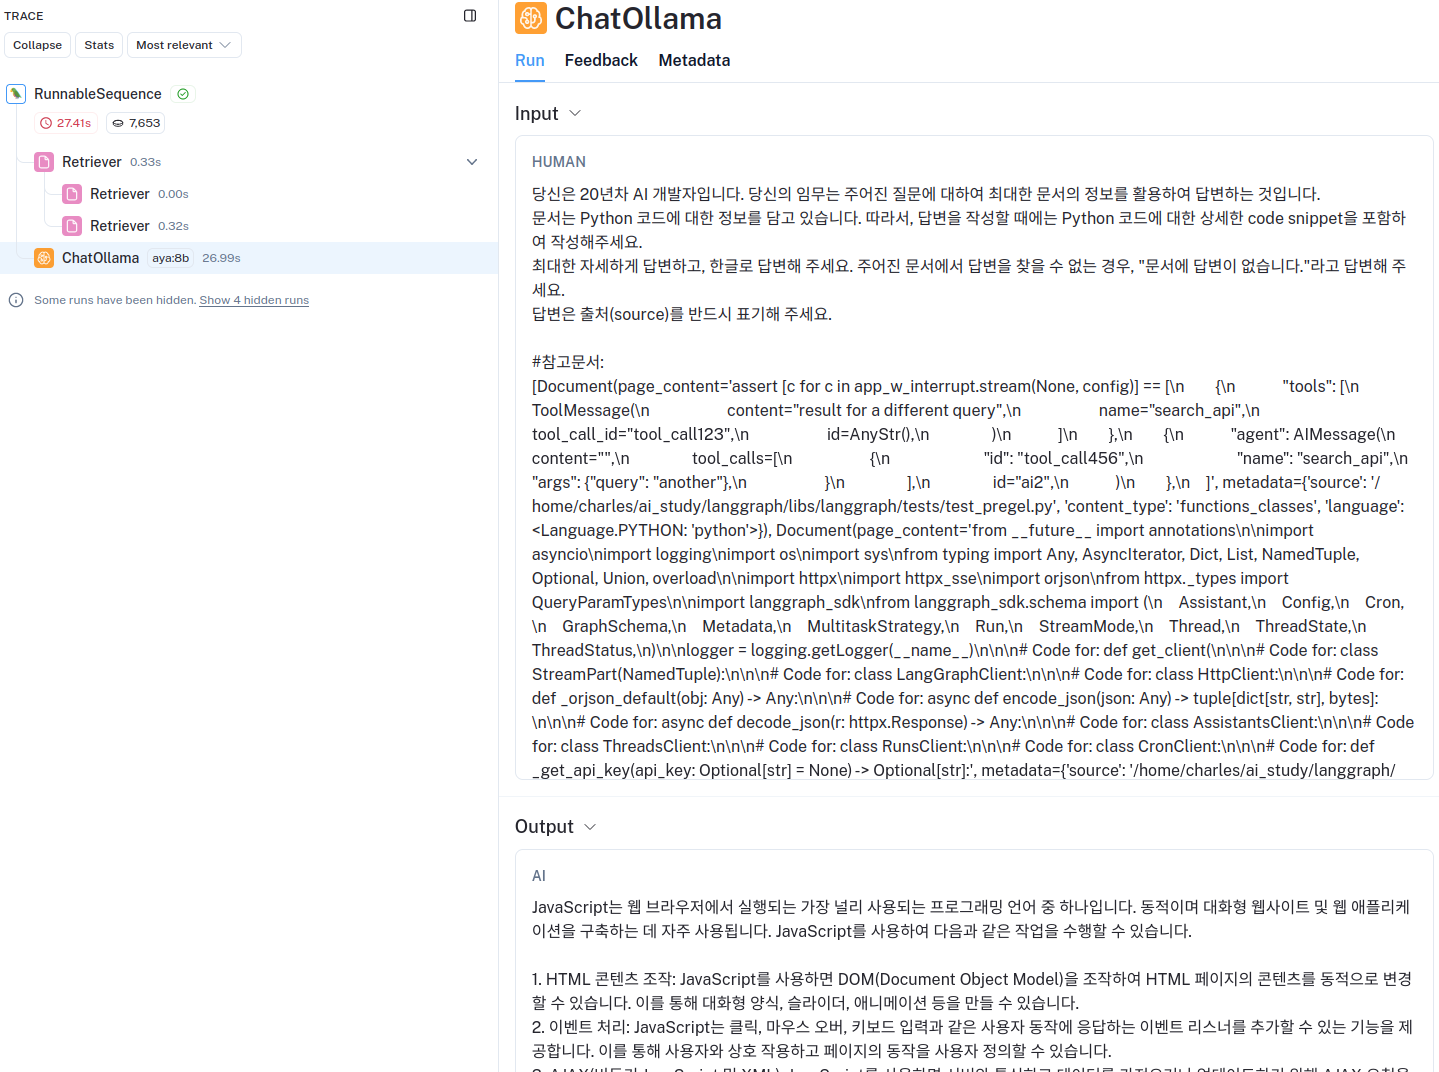

In [ ]:
answer = rag_chain.with_config(configurable={"llm": "claude"}).invoke(
    "PromptTemplate 사용방법을 알려주세요"
)

-------------------------------------

In [ ]:
answer = rag_chain.invoke("WebbaseLoader 사용법에 대해 알려주세요")

In [ ]:
answer = rag_chain.invoke(
    "retriever 의 get_relevant_documents 기능은 어떻게 사용하나요?"
)

In [ ]:
answer = rag_chain.invoke("Agent 에서 TavilySearch 도구를 사용하는 예시를 보여주세요.")